In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/soil-classification/soil_classification-2025/sample_submission.csv
/kaggle/input/soil-classification/soil_classification-2025/train_labels.csv
/kaggle/input/soil-classification/soil_classification-2025/test_ids.csv
/kaggle/input/soil-classification/soil_classification-2025/test/img_0f035b97.jpg
/kaggle/input/soil-classification/soil_classification-2025/test/img_f13af256.jpg
/kaggle/input/soil-classification/soil_classification-2025/test/img_15b41dbc.jpg
/kaggle/input/soil-classification/soil_classification-2025/test/img_cfb4fc7a.jpg
/kaggle/input/soil-classification/soil_classification-2025/test/img_683111fb.jpg
/kaggle/input/soil-classification/soil_classification-2025/test/img_c4bd7b3e.jpg
/kaggle/input/soil-classification/soil_classification-2025/test/img_4ccce0f8.jpg
/kaggle/input/soil-classification/soil_classification-2025/test/img_86faa98d.jpg
/kaggle/input/soil-classification/soil_classification-2025/test/img_c448342c.jpg
/kaggle/input/soil-classification/soil_cla

In [ ]:
"""
This code focuses on balancing a soil classification dataset by augmenting images 
for underrepresented soil types to ensure uniform class distribution.

It defines a custom PyTorch Dataset that supports both original and in-memory 
augmented images for seamless integration during training.

Train and validation DataLoaders are created with appropriate transformations 
to prepare the data for model training.
"""

import os
import pandas as pd
import numpy as np
import cv2
import random
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
import albumentations as A
from albumentations.pytorch import ToTensorV2
import torch

# Configuration
CONFIG = {
    "TRAIN_DIR": "/kaggle/input/soil-classification/soil_classification-2025/train",
    "CSV_PATH": "/kaggle/input/soil-classification/soil_classification-2025/train_labels.csv",
    "IMG_SIZE": 224,
    "SEED": 42,
    "BATCH_SIZE": 32
}

# Set seed
random.seed(CONFIG["SEED"])
np.random.seed(CONFIG["SEED"])
torch.manual_seed(CONFIG["SEED"])

# Load CSV
df = pd.read_csv(CONFIG["CSV_PATH"])

# Enhanced Augmentation for balancing
def augment_class(df, class_name, target_count):
    current_df = df[df['soil_type'] == class_name].reset_index(drop=True)
    images_needed = target_count - len(current_df)
    aug_images = []

    aug = A.Compose([
        A.Resize(CONFIG["IMG_SIZE"], CONFIG["IMG_SIZE"]),
        A.OneOf([
            A.HorizontalFlip(p=0.5),
            A.VerticalFlip(p=0.5),
            A.RandomRotate90(p=0.5),
        ], p=0.7),
        A.RandomBrightnessContrast(p=0.4),
        A.HueSaturationValue(p=0.3),
        A.RandomGamma(gamma_limit=(80, 120), p=0.3),
        A.CLAHE(clip_limit=4.0, tile_grid_size=(8, 8), p=0.3),
        A.OneOf([
            A.GaussianBlur(blur_limit=(3, 5), p=0.5),
            A.MotionBlur(p=0.3),
            A.MedianBlur(blur_limit=3, p=0.3),
        ], p=0.5),
        A.OneOf([
            A.Sharpen(alpha=(0.1, 0.3)),
            A.Emboss(alpha=(0.1, 0.3)),
        ], p=0.5),
        A.MultiplicativeNoise(multiplier=(0.9, 1.1), per_channel=True, p=0.3),
        A.ISONoise(intensity=(0.1, 0.3), color_shift=(0.01, 0.05), p=0.3),
        A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.05, rotate_limit=15, p=0.5),
        A.CoarseDropout(max_holes=8, max_height=16, max_width=16, fill_value=0, p=0.5),
        A.Normalize(),
        ToTensorV2()
    ])

    for i in tqdm(range(images_needed), desc=f"Augmenting {class_name}"):
        sample = current_df.iloc[i % len(current_df)]
        img_path = os.path.join(CONFIG["TRAIN_DIR"], sample['image_id'])
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        augmented = aug(image=image)['image']
        aug_images.append({
            'image': augmented,
            'label': class_name
        })

    return aug_images

# Balance all classes
max_count = df['soil_type'].value_counts().max()
augmented_data = []
for class_name in df['soil_type'].unique():
    class_count = df[df['soil_type'] == class_name].shape[0]
    if class_count < max_count:
        augmented_data += augment_class(df, class_name, max_count)

# Dataset Class
class BalancedSoilDataset(Dataset):
    def __init__(self, df, img_dir, transform=None, augmented=None):
        self.df = df.reset_index(drop=True)
        self.img_dir = img_dir
        self.transform = transform
        self.augmented = augmented or []
        self.label_map = {label: idx for idx, label in enumerate(sorted(df['soil_type'].unique()))}

    def __len__(self):
        return len(self.df) + len(self.augmented)

    def __getitem__(self, idx):
        if idx < len(self.df):
            row = self.df.iloc[idx]
            img_path = os.path.join(self.img_dir, row['image_id'])
            image = cv2.imread(img_path)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            label = self.label_map[row['soil_type']]
            if self.transform:
                image = self.transform(image=image)['image']
        else:
            aug_sample = self.augmented[idx - len(self.df)]
            image = aug_sample['image']
            label = self.label_map[aug_sample['label']]

        return image, label

# Transforms
def get_transforms(train=True):
    if train:
        return A.Compose([
            A.Resize(CONFIG["IMG_SIZE"], CONFIG["IMG_SIZE"]),
            A.RandomCrop(CONFIG["IMG_SIZE"], CONFIG["IMG_SIZE"]),
            A.HorizontalFlip(p=0.5),
            A.VerticalFlip(p=0.5),
            A.ShiftScaleRotate(shift_limit=0.15, scale_limit=0.1, rotate_limit=25, p=0.5),
            A.RandomBrightnessContrast(p=0.4),
            A.Normalize(),
            ToTensorV2()
        ])
    else:
        return A.Compose([
            A.Resize(CONFIG["IMG_SIZE"], CONFIG["IMG_SIZE"]),
            A.Normalize(),
            ToTensorV2()
        ])

# Train/Validation Split
train_df, val_df = train_test_split(df, test_size=0.2, stratify=df.soil_type, random_state=CONFIG["SEED"])

# Dataset and DataLoaders
train_dataset = BalancedSoilDataset(train_df, CONFIG["TRAIN_DIR"], transform=get_transforms(train=True), augmented=augmented_data)
val_dataset = BalancedSoilDataset(val_df, CONFIG["TRAIN_DIR"], transform=get_transforms(train=False))

train_loader = DataLoader(train_dataset, batch_size=CONFIG["BATCH_SIZE"], shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=CONFIG["BATCH_SIZE"], shuffle=False, num_workers=2)


/usr/local/lib/python3.11/dist-packages/albumentations/core/validation.py:87: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)
/tmp/ipykernel_35/2210664117.py:59: UserWarning: Argument(s) 'max_holes, max_height, max_width, fill_value' are not valid for transform CoarseDropout
  A.CoarseDropout(max_holes=8, max_height=16, max_width=16, fill_value=0, p=0.5),
Augmenting Black Soil: 100%|██████████| 297/297 [00:01<00:00, 170.33it/s]
/usr/local/lib/python3.11/dist-packages/albumentations/core/validation.py:87: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)


In [14]:
print(f"Original training samples: {len(train_df)}")
print(f"Original training samples: {len(val_dataset)}")
print(f"Augmented training samples: {len(augmented_data)}")
print(f"Total training samples: {len(train_dataset)}")


Original training samples: 977
Original training samples: 245
Augmented training samples: 890
Total training samples: 1867


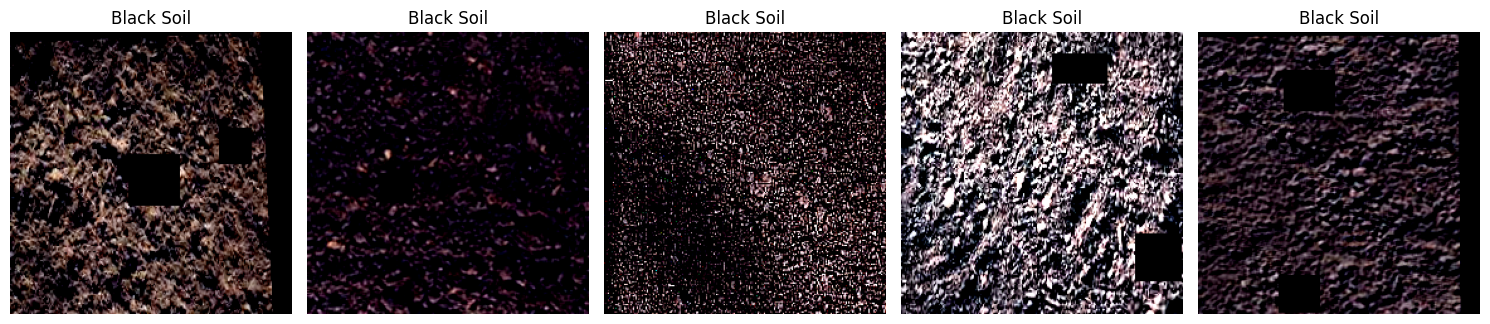

In [15]:
import matplotlib.pyplot as plt
import random
import numpy as np

def visualize_augmented_images(augmented_data, class_name, n=5):
    """
    Visualizes n augmented images for a specific class from the augmented_data list.
    Each item in the list is a dictionary with keys: 'image' and 'label'.
    """
    # Filter images belonging to the specified class
    filtered = [item for item in augmented_data if item['label'] == class_name]

    # Select a random sample
    selected = random.sample(filtered, min(n, len(filtered)))

    # Plot the selected images
    plt.figure(figsize=(15, 5))
    for idx, item in enumerate(selected):
        image = item['image']

        # If image is in PyTorch format (C, H, W), convert it to (H, W, C)
        if isinstance(image, torch.Tensor):
            image = image.permute(1, 2, 0).numpy()

        # Rescale from [-1, 1] to [0, 1] if normalized (ImageNet normalization assumed)
        img = (image * 0.5) + 0.5
        img = np.clip(img, 0, 1)

        plt.subplot(1, n, idx + 1)
        plt.imshow(img)
        plt.title(item['label'])
        plt.axis('off')
    plt.tight_layout()
    plt.show()
visualize_augmented_images(augmented_data, class_name="Black Soil", n=5)
